In [172]:
%matplotlib inline

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [174]:
from chainer import Chain,Variable
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.datasets import split_dataset_random
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater,Trainer
from chainer.training.extensions import PrintReport,LogReport,Evaluator
from sklearn.preprocessing import StandardScaler
from chainer.datasets import TupleDataset
from chainer.optimizers import Adam
from sklearn.metrics import classification_report
from chainer.dataset.convert import concat_examples

In [175]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [176]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# 入力データと正解データに分割
train_x = train.iloc[:,1:].values.astype(np.float32)
train_y = train.iloc[:,0].values.astype(np.int32)
test_x = test.values.astype(np.float32)

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
# 訓練用データと検証用データに分割
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, train_size=0.8, random_state=1)

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [181]:
# CNN用にデータの持ち方を変換
train_x = train_x.reshape((len(train_x),1,28,28))
valid_x = valid_x.reshape((len(valid_x),1,28,28))
test_x = test_x.reshape((len(test_x),1,28,28))

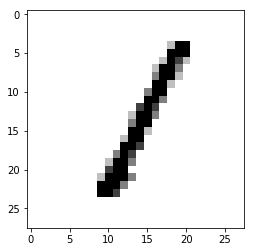

In [182]:
plt.imshow(train_x[0][0],cmap=cm.gray_r,interpolation='nearest')

In [183]:
train_x = train_x / 255
valid_x = valid_x /255

In [184]:
train_dataset = TupleDataset(train_x,train_y)
valid_dataset = TupleDataset(valid_x,valid_y)

In [226]:
#モデルの定義
class CNN(chainer.Chain):
    def __init__(self):
        super(CNN,self).__init__()
        with self.init_scope():
            # 第1引数：入力チャネル数、第2引数：出力チャネル数、第3引数：フィルタサイズ
            self.conv1 = L.Convolution2D(1,32,5)
            self.batch1 = L.BatchNormalization(32)
            self.conv2 = L.Convolution2D(32,64,5)
            self.batch2 = L.BatchNormalization(64)
            self.l1 = L.Linear(1024,10)
    
    def __call__(self,x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)),2)
        h = self.batch1(h)
        h = F.max_pooling_2d(F.relu(self.conv2(h)),2)
        h = self.batch2(h)
        h = F.dropout(h,ratio=0.5)
        return self.l1(h)

In [214]:
# AlexNetモデルの定義
class AlexNet(chainer.Chain):
    def __init__(self):
        super(AlexNet,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(1,96,11,stride=4)
            self.batch1 = L.BatchNormalization(96)
            
            self.conv2 = L.Convolution2D(96,256,5,pad=2)
            self.batch2 = L.BatchNormalization(256)
            
            self.conv3 = L.Convolution2D(256,384,3,pad=1)
            self.conv4 = L.Convolution2D(384,384,3,pad=1)
            self.conv5 = L.Convolution2D(384,256,3,pad=1)
            
            self.fc1 = L.Linear(4096)
            self.fc2 = L.Linear(4096)
            self.fc3 = L.Linear(10)
        
    def __call__(self,x):
        h = F.max_pooling_2d(self.batch1(F.relu(self.conv1(x))),3,stride=2)
        h = F.max_pooling_2d(self.batch2(F.relu(self.conv2(h))),3,stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)),2,stride=2)
        h = F.relu(self.fc1(h))
        h = F.dropout(h,ratio=0.5)
        h = F.relu(self.fc2(h))
        h = F.dropout(h,ratio=0.5)
        return self.fc3(h)

In [227]:
# ミニバッチの作成
train_iterator = SerialIterator(train_dataset,batch_size = 100 , repeat=True)
valid_iterator = SerialIterator(valid_dataset,batch_size = 100 , shuffle=False,repeat=False)

In [228]:
# 学習の実行
model = CNN()
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(10000,'iteration'))
trainer.extend(Evaluator(valid_iterator,classifier),trigger=(100,'iteration'))
trainer.extend(PrintReport(['iteration','main/loss','validation/main/loss', 'main/accuracy', 'validation/main/accuracy']))
logreport = LogReport(trigger=(100,'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
100         0.421776    0.131056              0.866          0.961429                  
200         0.148087    0.086422              0.9552         0.974524                  
300         0.112457    0.0735457             0.965          0.977976                  
400         0.0877891   0.0626412             0.9729         0.980952                  
500         0.0737421   0.0570551             0.9761         0.983214                  
600         0.0706701   0.0557043             0.9773         0.982976                  
700         0.0606199   0.0524254             0.9818         0.985119                  
800         0.0499878   0.0525838             0.9833         0.984286                  
900         0.0498422   0.0497728             0.9845         0.985119                  
1000        0.0518507   0.0466805             0.9824         0.985119                  
1100        0.0472263   0.0501767 

9100        0.00801817  0.045964              0.9969         0.991786                  
9200        0.00674563  0.0447297             0.9974         0.990952                  
9300        0.00962488  0.0457165             0.9963         0.991548                  
9400        0.00817056  0.0440156             0.9971         0.990833                  
9500        0.00856851  0.0507746             0.997          0.990714                  
9600        0.00903468  0.0466263             0.9969         0.99131                   
9700        0.00771739  0.0539612             0.9969         0.989286                  
9800        0.00717819  0.0487454             0.997          0.990476                  
9900        0.00839095  0.048912              0.9972         0.989762                  


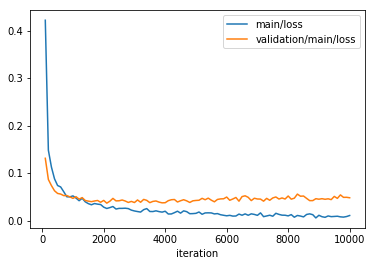

In [229]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

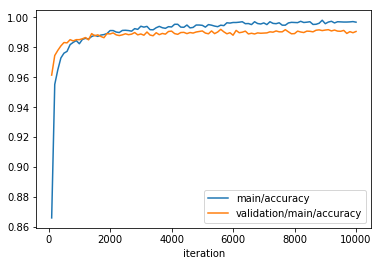

In [230]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[[ 'main/accuracy', 'validation/main/accuracy']].values, columns=[ 'main/accuracy', 'validation/main/accuracy'], index=log_df["iteration"]).plot()

In [231]:
y = model(test_x)

In [232]:
pred = np.argmax(y.data,axis=1)

In [233]:
# 提出用にフォーマットを作成
submissions = pd.DataFrame({"ImageId": list(range(1,len(pred)+1)),"Label":pred})

In [234]:
# CSVへの書き出し
submissions.to_csv("digit_cnn_output_lenet_180721.csv", index=False, header=True)